## **Setup**

##### install wandb

In [ ]:
!pip install wandb   # run this command to insatll wandb on colab - worth it!

     |████████████████████████████████| 1.7MB 9.3MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 163kB 49.1MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 122kB 34.7MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=c0635852fff78d15fd6488d146a3642cc7dae9b331896c74a6d4261f9b1b2512
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=b6e65346828e51018fdb154fc740702fe6152de026e9963ce9166cd72290f8bb
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=5b943c6245698352283f4b4353a056ac8b592736828

##### setup

In [ ]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

import wandb
from wandb.keras import WandbCallback

from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored
import seaborn as sns

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [ ]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


In [ ]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**



### Loading python scripts

All functions will be used in the "Training the Model" section.

In [ ]:
# paths for the datasets
experiment_auxiliary_path = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
synthetic_auxiliary_path = 'MAFAT RADAR Challenge - Auxiliary Synthetic Set V2'
train_path = 'MAFAT RADAR Challenge - Training Set V1'
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'

In [ ]:
files_path = mount_path + "My Drive/Final Project ITC/MAFAT Challenge/Our notebooks"
sys.path.append(files_path)

In [ ]:
from loading_functions import load_data, load_pkl_data, load_csv_metadata, load_data_all_datasets, append_dict
from spectogram_plots import plot_shited_spectrogram, plot_recenter_midline_spectrogram, spectrogram_cmap
from model_roc_function import stats
from data_augmentation import  recenter_midline, shift_spectrogram
from data_preprocessing_funcs import data_preprocess
from plot_learning_curve import plot_loss_and_accuracy_over_epoches
from data_augmentation import recenter_midline, shift_spectrogram
from full_loading_and_process import process_and_split_data
from sampling_data import subsampling, subsampling_segments_target_ratio, balance_target, split_x_y, split_train_val


np.save('/content/cmap.npy', spectrogram_cmap)

### model configurations - dict

In [ ]:
model_input = {
                'model_conf' : {
                              'sota_model': "L3",
                              'sota_model_layer': "env",
                              'input_last_channel': 1,
                              'batch_norm': False,
                              'batch_size':64,
                              'no_epochs':100,
                              'learning_rate': 0.002,
                              'monitor': 'val_accuracy',
                              "dropout": 0.2
                              },
               'callback' : {'early_stop':{
                                           'patience':10,
                                           'verbose': 1
                                          },
                            'model_checkpoint':{
                                                'flag':True,
                                                'file_path':f"{mount_path}My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/saved_models",
                                                'save_weights_only':False,
                                                'verbose': 1
                                                }
                            },      
                }

### **Splitting the Training set**



The functions below split the training set into Train and Validation sets.

the logic: 

- take the full training set and split it to train and validation according to track id and make sure to that there are no segments of the same track in the training and in the validation (similar to the approach of MAFAT)
- To do the split in the easiest way, we will take still only geolocations 1 and 4 but this time the sampling of the segments will use the subsampling function

- to the x_train we will add data from the expeirment and from the synthetic datasets, using sampling- making sure the the number will lead to balanced data between animal and humans in the end  

In [ ]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset

# function is part of the python scripts

## **Model functions**

### **FC model** using the embeding


In [ ]:
def emb_model(init, embeding_layer, first_layer_length, dropout):

  model_num_wandb = wandb.run.name.rsplit("-")[-1]

  model = Sequential(name=f"embeding_{model_num_wandb}_{embeding_layer}")

  model.add(Dense(2048, activation='relu',  kernel_initializer = init))
  model.add(Dropout(dropout))
  model.add(Dense(1024, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dropout(dropout))
  model.add(Dense(512, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dropout(dropout))
  model.add(Dense(256, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dropout(dropout))
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dropout(dropout))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))

  return model

## Loading the data


#### loading the data and pre-processing

In [ ]:
l3_emb_path = mount_path + "/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/saved_models/embeding_inbar_30_9.pickle"

with open(l3_emb_path, 'rb') as handle:
    emd_dict = pickle.load(handle)

In [ ]:
x_emb_train_env = np.concatenate(emd_dict['x_emb_train']['evn'])
x_emb_train_mus = np.concatenate(emd_dict['x_emb_train']['mus'])
x_emb_val_env = np.concatenate(emd_dict['x_emb_val']['evn'])
x_emb_val_mus = np.concatenate(emd_dict['x_emb_val']['mus'])

train_y = emd_dict['train_y']
val_y = emd_dict['val_y']

In [ ]:
x_emb_train_env.shape, x_emb_train_mus.shape, x_emb_val_env.shape, x_emb_val_mus.shape

((5584, 8192), (5584, 8192), (446, 8192), (446, 8192))

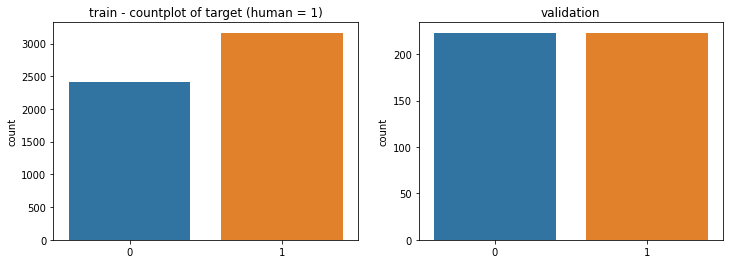

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(12,4))
sns.countplot(x=train_y, ax=ax[0])
sns.countplot(x=val_y, ax=ax[1])

ax[0].set_title("train - countplot of target (human = 1)")
ax[1].set_title("validation");

## **Training The Model functions**

#### model callbacks + Wandb config

In [ ]:
def callbacks(model, final_model_path):
     
    mc = tf.keras.callbacks.ModelCheckpoint(final_model_path,
                                            monitor= model_input['model_conf']['monitor'],
                                            verbose= model_input['callback']['model_checkpoint']['verbose'],
                                            save_best_only=True,
                                            save_weights_only=False,
                                            ) 
    earlystop = EarlyStopping(patience= model_input['callback']['early_stop']['patience'], 
                              monitor = model_input['model_conf']['monitor'],
                              verbose = model_input['callback']['early_stop']['verbose'])
    return mc, earlystop

### wandb connfig and build model

In [ ]:
def wandb_config():

  wandb.init(project="MAFAT",
            config={
                'sota_model':        model_input['model_conf']["sota_model"],
                'sota_model_layer':  model_input['model_conf']["sota_model_layer"],
                'input_last_channel':model_input['model_conf']['input_last_channel'],
                "batch_size":        model_input['model_conf']["batch_size"],
                "no_epochs":         model_input['model_conf']["no_epochs"],
                "learning_rate":     model_input['model_conf']["learning_rate"],
                "data_extraction":   emd_dict["data_extraction"],
                'batch_norm':        model_input['model_conf']['batch_norm'],
                "dropout":          model_input['model_conf']['dropout']
            })

In [ ]:
def build_model_embedding(input_shape):
  """
  buliding the model according to the config dict
  important to chose sota_model, sota_model_layer, input_last_channel
  """
  loss_function = BinaryCrossentropy()
  optimizer = Adam(learning_rate = wandb.config.learning_rate)
  init = tf.keras.initializers.GlorotNormal(seed = 0)

  model = emb_model(init, wandb.config.sota_model_layer, input_shape, wandb.config.dropout)  
  model.compile(loss=loss_function, optimizer=optimizer, metrics=['AUC', 'accuracy'])

  folder_models_path = model_input['callback']['model_checkpoint']['file_path']

  final_model_path = f'{folder_models_path}/{model.name}.h5'
  mc, earlystop = callbacks(model, final_model_path) 


  return model, mc, earlystop, final_model_path

### run single model, run several layers and plot results

In [ ]:
def plot_roc_curve_of_models(final_model_path, train_x, val_x):

  print(f"model: {final_model_path.rsplit('/')[-1]}")
  final_model = tf.keras.models.load_model(final_model_path)
  # Plot ROC curve and show ROC-AUC results of the training and validation sets. 
  pred = [final_model.predict(train_x), final_model.predict(val_x)]
  actual = [train_y, val_y]
  stats(pred, actual)

In [ ]:
def prepare_model_and_wandb():
    wandb_config()
    if wandb.config.sota_model_layer == "env":
      x_train = x_emb_train_env
      x_val = x_emb_val_env
    elif wandb.config.sota_model_layer == "mus":
      x_train = x_emb_train_mus
      x_val = x_emb_val_mus
    elif wandb.config.sota_model_layer == "both":
      x_train = x_emb_train_both
      x_val = x_emb_val_both
    else:
      print("you didn't fill a model")

    model, mc, earlystop, final_model_path = build_model_embedding(x_train.shape[1])

    return model, mc, earlystop, final_model_path, x_train, x_val

## run the model

### env

In [ ]:
model_input['model_conf']["sota_model_layer"] = "env"


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:

model, mc, earlystop, final_model_path, x_train, x_val = prepare_model_and_wandb()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
model.summary()

Model: "embeding_124_env"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2048)              16779264  
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)          

In [ ]:
history = model.fit(x_train, train_y,
                        batch_size=wandb.config.batch_size,
                        epochs=wandb.config.no_epochs,
                        verbose=1,
                        validation_data=(x_val, val_y),
                        validation_steps=len(x_val) // wandb.config.batch_size,
                        callbacks=[mc, earlystop, WandbCallback(validation_data=(x_val, val_y))])

Epoch 1/100
86/88 [============================>.] - ETA: 0s - loss: 12.5346 - auc: 0.5037 - accuracy: 0.5441
Epoch 00001: val_accuracy improved from -inf to 0.58073, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/embeding_124_env.h5
88/88 [==============================] - 3s 31ms/step - loss: 12.4596 - auc: 0.5037 - accuracy: 0.5437 - val_loss: 7.2020 - val_auc: 0.7199 - val_accuracy: 0.5807
Epoch 2/100
86/88 [============================>.] - ETA: 0s - loss: 5.6435 - auc: 0.8442 - accuracy: 0.7411
Epoch 00002: val_accuracy improved from 0.58073 to 0.79948, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/embeding_124_env.h5
88/88 [==============================] - 3s 39ms/step - loss: 5.6258 - auc: 0.8455 - accuracy: 0.7421 - val_loss: 4.5231 - val_auc: 0.8542 - val_accuracy: 0.7995
Epoch 3/100
86/88 [============================>.] - ETA: 0s - loss: 3.6421 - auc: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

KeyboardInterrupt



#### plot results

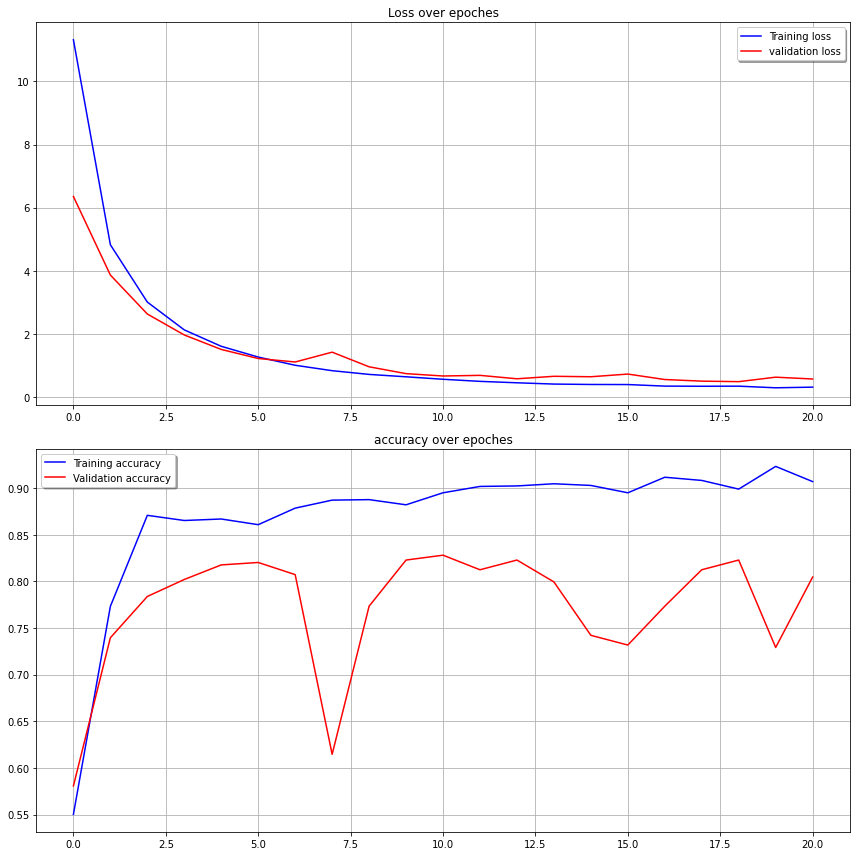

In [ ]:
plot_loss_and_accuracy_over_epoches(history)

model: embeding_116_env.h5


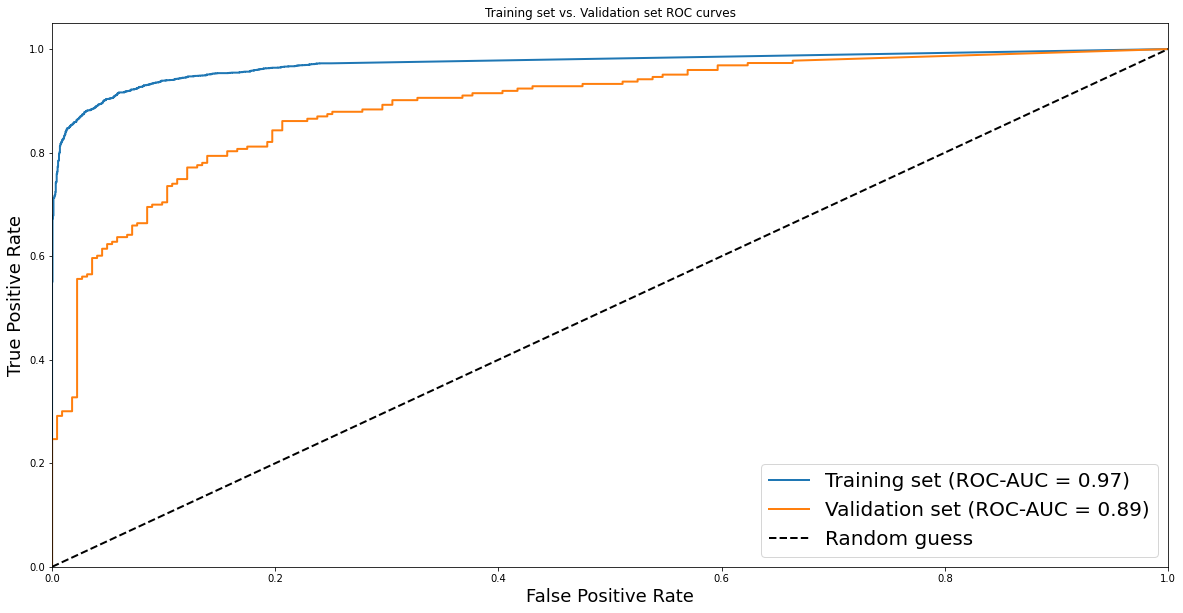

In [ ]:
plot_roc_curve_of_models(final_model_path, x_emb_train_env, x_emb_val_env)

### check with mus

In [ ]:
model_input['model_conf']["sota_model_layer"] = "mus"
model, mc, earlystop, final_model_path, x_train, x_val = prepare_model_and_wandb()

history = model.fit(x_train, train_y,
                        batch_size=wandb.config.batch_size,
                        epochs=wandb.config.no_epochs,
                        verbose=1,
                        validation_data=(x_val, val_y),
                        validation_steps=len(x_val) // wandb.config.batch_size,
                        callbacks=[mc, earlystop, WandbCallback(validation_data=(x_val, val_y))])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,20
loss,0.31094
auc,0.95361
accuracy,0.90706
val_loss,0.56901
val_auc,0.90137
val_accuracy,0.80469
_step,20
_runtime,274
_timestamp,1601468306
best_val_loss,0.48502


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
auc,▁▆▇▇▇▇▇▇█████████████
accuracy,▁▅▇▇▇▇▇▇▇▇▇████▇█████
val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_auc,▁▄▅▃▇▇▇▇▇▇▇██▇▇██████
val_accuracy,▁▅▇▇██▇▂▆████▇▆▅▆██▅▇
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
_runtime,▁▁▁▂▃▄▄▅▅▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▃▄▄▅▅▆▇▇▇▇▇▇▇▇███


Epoch 1/100
85/88 [===========================>..] - ETA: 0s - loss: 11.3748 - auc: 0.5079 - accuracy: 0.5421
Epoch 00001: val_accuracy improved from -inf to 0.58073, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/embeding_117_mus.h5
88/88 [==============================] - 3s 31ms/step - loss: 11.2429 - auc: 0.5094 - accuracy: 0.5430 - val_loss: 6.1617 - val_auc: 0.7813 - val_accuracy: 0.5807
Epoch 2/100
84/88 [===========================>..] - ETA: 0s - loss: 4.6257 - auc: 0.8653 - accuracy: 0.7547
Epoch 00002: val_accuracy improved from 0.58073 to 0.78906, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/embeding_117_mus.h5
88/88 [==============================] - 26s 291ms/step - loss: 4.5798 - auc: 0.8693 - accuracy: 0.7600 - val_loss: 3.5546 - val_auc: 0.8349 - val_accuracy: 0.7891
Epoch 3/100
83/88 [===========================>..] - ETA: 0s - loss: 2.7632 - auc

#### plot results

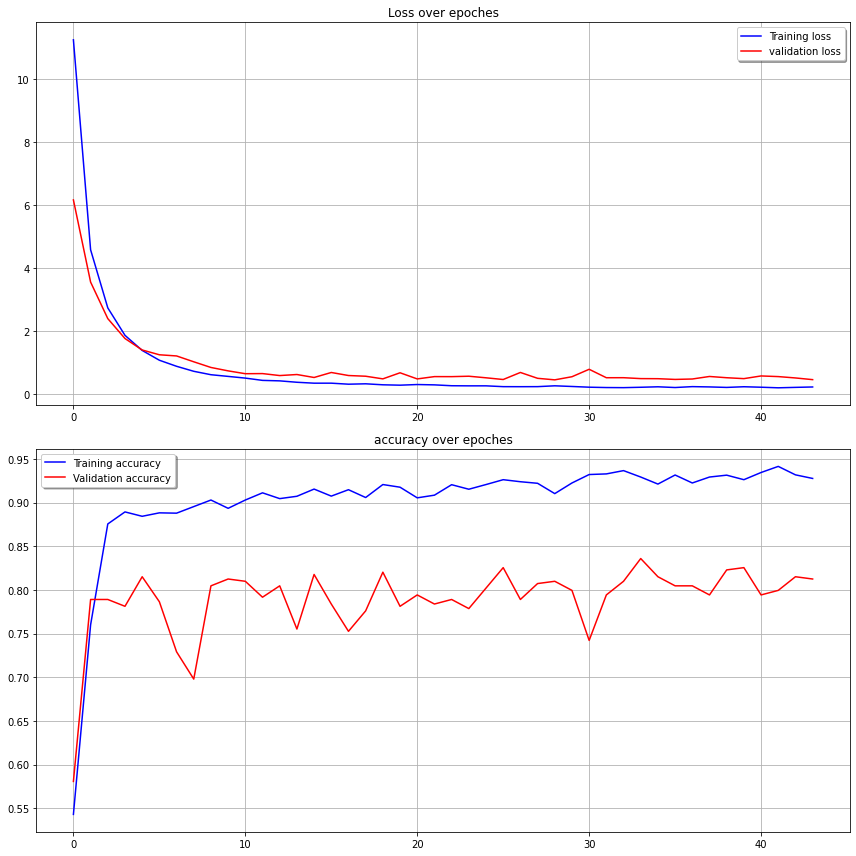

In [ ]:
plot_loss_and_accuracy_over_epoches(history)

model: embeding_117_mus.h5


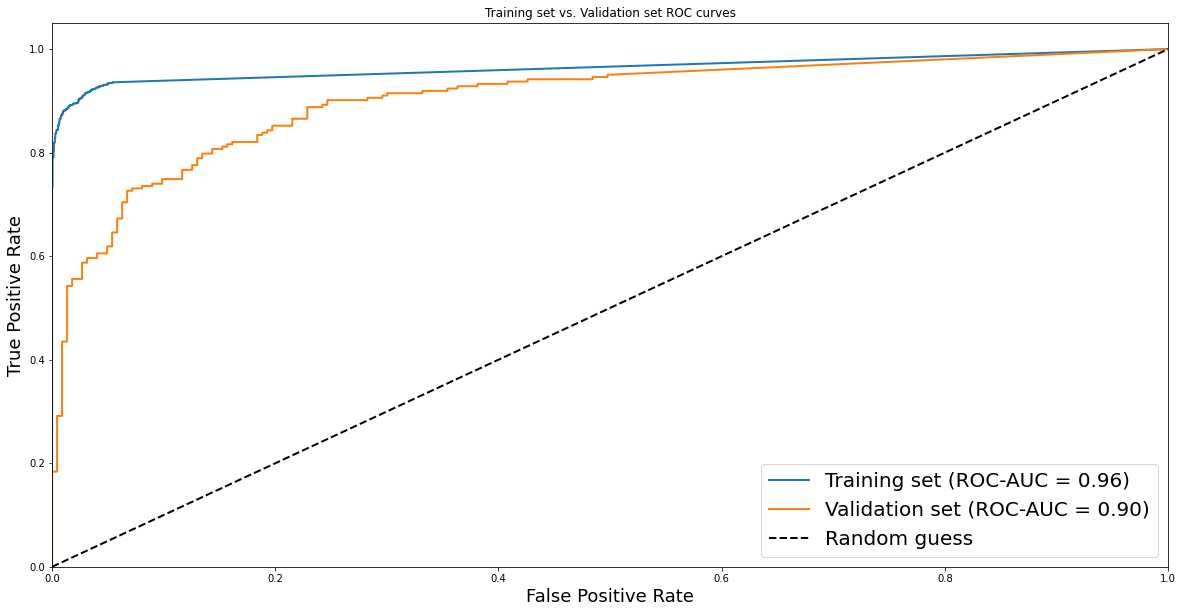

In [ ]:
plot_roc_curve_of_models(final_model_path, x_emb_train_mus, x_emb_val_mus)

### check both

In [ ]:
x_emb_train_both = np.concatenate([x_emb_train_env, x_emb_train_mus], axis=1)
x_emb_val_both = np.concatenate([x_emb_val_env, x_emb_val_mus], axis=1)

In [ ]:
x_emb_train_both.shape, x_emb_val_both.shape

((5584, 16384), (446, 16384))

In [ ]:
model_input['model_conf']["sota_model_layer"] = "both"
model, mc, earlystop, final_model_path, x_train, x_val = prepare_model_and_wandb()

history = model.fit(x_train, train_y,
                        batch_size=wandb.config.batch_size,
                        epochs=wandb.config.no_epochs,
                        verbose=1,
                        validation_data=(x_val, val_y),
                        validation_steps=len(x_val) // wandb.config.batch_size,
                        callbacks=[mc, earlystop, WandbCallback(validation_data=(x_val, val_y))])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,43
loss,0.22648
auc,0.96447
accuracy,0.92765
val_loss,0.45916
val_auc,0.89839
val_accuracy,0.8125
_step,43
_runtime,343
_timestamp,1601468692
best_val_loss,0.45278


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
auc,▁▆▇▇████████████████████████████████████
accuracy,▁▅▇▇▇▇▇▇▇▇▇▇▇█▇█▇██▇██████▇█████████████
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auc,▁▄▆▆▆▆▇▇▇▇▇▆▇▇▇▇█▇▇▇▇█▇█▇██▇▇▇█▇███▇█▇▇▇
val_accuracy,▁▇▇▆▇▇▅▄▇▇▇▇▆▇▇▆▆█▆▇▇▆▇█▇▇▇▇▅▇█▇▇▇▇██▇▇▇
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████


Epoch 1/100
85/88 [===========================>..] - ETA: 0s - loss: 13.5506 - auc: 0.4978 - accuracy: 0.5329
Epoch 00001: val_accuracy improved from -inf to 0.58073, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/embeding_118_both.h5
88/88 [==============================] - 11s 128ms/step - loss: 13.4040 - auc: 0.4985 - accuracy: 0.5340 - val_loss: 7.7763 - val_auc: 0.6349 - val_accuracy: 0.5807
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 6.3187 - auc: 0.8070 - accuracy: 0.7136
Epoch 00002: val_accuracy improved from 0.58073 to 0.67708, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/embeding_118_both.h5
88/88 [==============================] - 76s 863ms/step - loss: 6.3187 - auc: 0.8070 - accuracy: 0.7136 - val_loss: 5.3291 - val_auc: 0.8414 - val_accuracy: 0.6771
Epoch 3/100
86/88 [============================>.] - ETA: 0s - loss: 4.3478 -

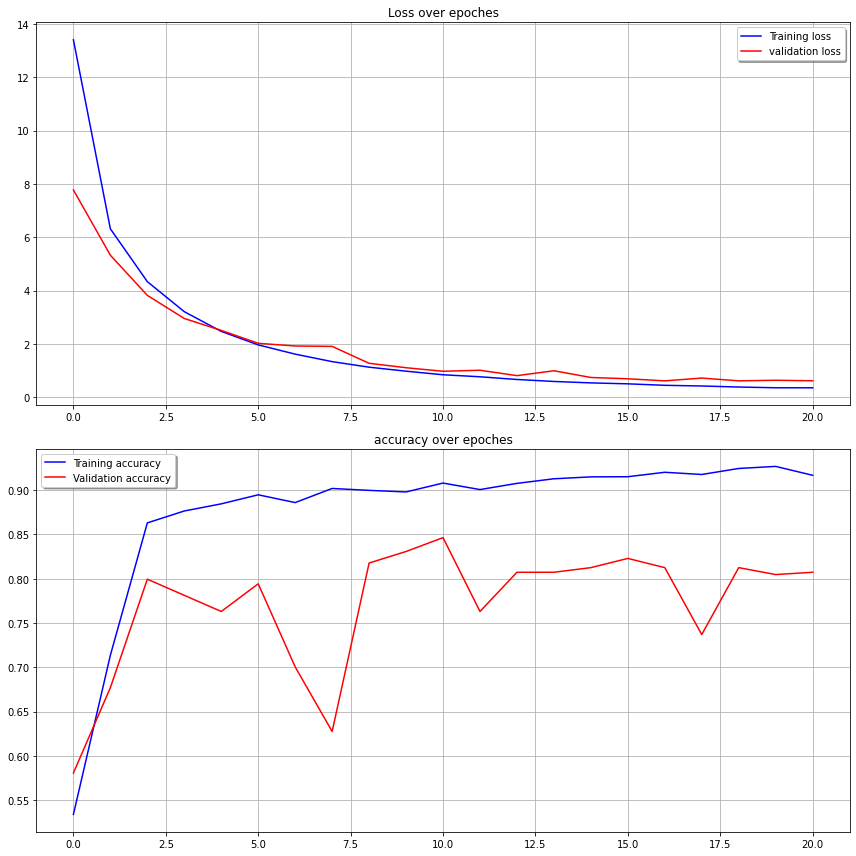

In [ ]:
plot_loss_and_accuracy_over_epoches(history)

model: embeding_118_both.h5


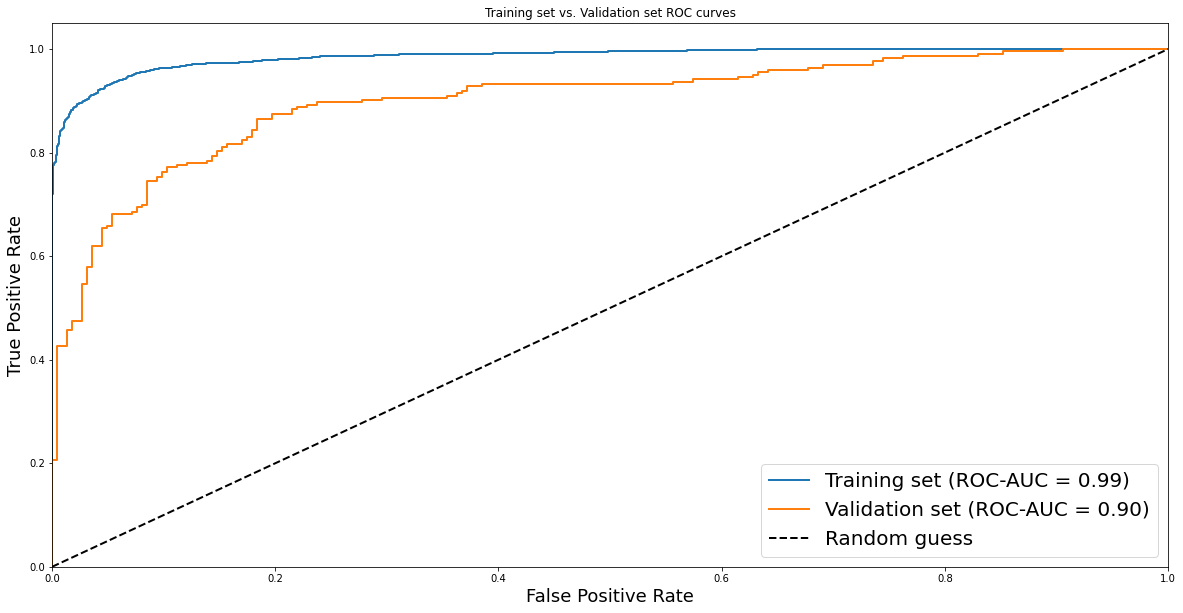

In [ ]:
plot_roc_curve_of_models(final_model_path, x_emb_train_both, x_emb_val_both)

## submissiom

#### load pickle file of test data

In [ ]:
l3_emb_test_data = mount_path + "/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/saved_models/embeding_inbar_test_data.pickle"

with open(l3_emb_test_data, 'rb') as handle:
    emd_dict_test = pickle.load(handle)

In [ ]:
x_emb_test_env = np.concatenate(emd_dict_test['x_emb_test']['evn'])
x_emb_test_mus = np.concatenate(emd_dict_test['x_emb_test']['mus'])

test_df = emd_dict_test['test_df']

In [ ]:
x_emb_test_both = x_emb_val_both = np.concatenate([x_emb_test_env, x_emb_test_mus], axis=1)

In [ ]:
x_emb_test_both.shape

(106, 16384)

In [ ]:
final_model_path = model_input['callback']['model_checkpoint']['file_path'] + "/embeding_118_both.h5" 

In [ ]:
final_model = tf.keras.models.load_model(final_model_path)

# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = final_model.predict(x_emb_test_both)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

submission_file_name = model_name.split(".")[0] + ".zip"

# Download zip file
from zipfile import ZipFile
from google.colab import files

with ZipFile(submission_file_name, 'w') as myzip:
  myzip.write('submission.csv')

files.download(submission_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>